##### Notebook implementation of the following research article:

*The Spectrum of Asynchronous Dynamics in Spiking Networks:
A Theory for the Diversity of Non-Rhythmic Waking states in Neocortex*

by **Y. Zerlaut\*, S. Zucca\*, S. Panzeri# & T. Fellin#** $\qquad \qquad$     \*Co-first, #Co-last authors

---------------------------------------------------------------------
N.B. This actually reproduces _all results_, so it's a bit long, if you are just looking for a demo file of the network model, e.g. in [Brian2](http://brian2.readthedocs.io/en/stable/), check:

https://github.com/yzerlaut/notebook_papers/blob/master/sparse_vs_balanced/demo_Fig3.py

This reproduces Figure 3 of the paper, i.e.:

<img src="sparse_vs_balanced/demo_Fig3.png" width="400"/>

We also illustrate the analysis of the experimental data on a mini-sample of the data (a single cell, on a short period, downsampled at 500Hz, to have light datafile). The real dataset is available upon request to the lead contact.

## Summary 
In awake animals, diverse non-rhythmic network states have been experimentally reported. However, a theoretical model which explains how these different activity states may emerge within the same network is lacking. Here, we demonstrate that, under the constraint of moderate recurrent interactions, spiking networks exhibit a spectrum of asynchronous dynamics ranging from excitatory-dominated sparse activity regimes to balanced dense activity states upon the modulation of their level of afferent excitation. The model predicted regime-specific relationships between neural biophysical properties which were experimentally validated by intracellular recordings in the mouse somatosensory cortex. Moreover, theoretical analysis showed that sparse activity states precisely encoded complex patterns of presynaptic activity while dense activity states displayed strong population responsiveness to afferent inputs. These results provide a theoretical description for the diversity of non-rhythmic waking states in neocortex and suggest how, by moving along this spectrum, neural networks optimize their computation of incoming inputs.

In [1]:
"""
Necessary modules
"""
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from graphs.my_graph import * # my custom module for ~nice plots
import sys, os, scipy, brian2

# all figures will be saved to svg on the desktop for inclusions in multipanels
desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop')+os.path.sep
# some colors used all along the study
Blue, Orange, Green, Red, Purple = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
Inter = get_linear_colormap(Blue, Orange)(.5) # for the intermediate regime

In [2]:
# -------------------------------------------
#     tested under the following setting
# -------------------------------------------
print('Numpy version: ', np.__version__)
print('SciPy version: ', scipy.__version__)
print('Matplotlib version: ', plt.__version__)
print('Brian2 version: ', brian2.__version__)

Numpy version:  1.13.3
SciPy version:  1.0.0
Matplotlib version:  1.13.3
Brian2 version:  2.0.1


## Baseline parameters

*N.B. UNIT SYSTEM is : ms, mV, pF, nS, pA, Hz (arbitrary and unconsistent, so see code)*

We first write a set of parameters that will be used all along the study, passing options to the individual scripts will allow to override those parameters

In [3]:
S = """
Model = {
    ## -----------------------------------------------------------------------
    ### Initialisation by default parameters
    ## UNIT SYSTEM is : ms, mV, pF, nS, pA, Hz (arbitrary and unconsistent, so see code)
    ## -----------------------------------------------------------------------

    # numbers of neurons in population
    'N_RecExc':4000, 'N_RecInh':1000, 'N_AffExc':100, 'N_DsInh':500,
    # synaptic weights
    'Q_RecExc_RecExc':2., 'Q_RecExc_RecInh':2., 
    'Q_RecInh_RecExc':10., 'Q_RecInh_RecInh':10., 
    'Q_AffExc_RecExc':4., 'Q_AffExc_RecInh':4., 
    'Q_AffExc_DsInh':4.,
    'Q_DsInh_RecInh':10., 
    # synaptic time constants
    'Tse':5., 'Tsi':5.,
    # synaptic reversal potentials
    'Ee':0., 'Ei': -80.,
    # connectivity parameters
    'p_RecExc_RecExc':0.05, 'p_RecExc_RecInh':0.05, 
    'p_RecInh_RecExc':0.05, 'p_RecInh_RecInh':0.05, 
    'p_AffExc_RecExc':0.1, 'p_AffExc_RecInh':0.1, 
    'p_AffExc_DsInh':0.,
    'p_DsInh_RecInh':0.05, 
    # afferent stimulation
    'F_AffExc':10., 'F_DsInh':0.,
    # recurrent activity (for single cell simulation only)
    'F_RecExc':1., 'F_RecInh':1.,
    # simulation parameters
    'dt':0.1, 'tstop': 100., 'SEED':3, # low by default, see later
    ## ---------------------------------------------------------------------------------
    # === cellular properties (based on AdExp), population by population ===
    # --> Excitatory population (RecExc, recurrent excitation)
    'RecExc_Gl':10., 'RecExc_Cm':200.,'RecExc_Trefrac':5.,
    'RecExc_El':-70., 'RecExc_Vthre':-50., 'RecExc_Vreset':-70., 'RecExc_delta_v':0.,
    'RecExc_a':0., 'RecExc_b': 0., 'RecExc_tauw':1e9,
    # --> Inhibitory population (RecInh, recurrent inhibition)
    'RecInh_Gl':10., 'RecInh_Cm':200.,'RecInh_Trefrac':5.,
    'RecInh_El':-70., 'RecInh_Vthre':-53., 'RecInh_Vreset':-70., 'RecInh_delta_v':0.,
    'RecInh_a':0., 'RecInh_b': 0., 'RecInh_tauw':1e9,
    # --> Disinhibitory population (DsInh, disinhibition)
    'DsInh_Gl':10., 'DsInh_Cm':200.,'DsInh_Trefrac':5.,
    'DsInh_El':-70., 'DsInh_Vthre':-50., 'DsInh_Vreset':-70., 'DsInh_delta_v':0.,
    'DsInh_a':0., 'DsInh_b': 0., 'DsInh_tauw':1e9
}

# now let's say that we will modify or add a parameter in 'Model', we will execute scripts with the new statement:
def pass_arguments_of_new_model(Model):
    S = ''
    for key, val in Model.items():
        S += ' --'+key+' '+str(val)
    return S

import argparse
parser=argparse.ArgumentParser(description='Model parameters',formatter_class=argparse.RawTextHelpFormatter)
"""    
exec(S)
for key, val in Model.items():
    S += 'parser.add_argument("--'+key+'", type='+val.__class__.__name__+', default='+str(val)+') \n'

txt_file = open('sparse_vs_balanced/model.py', 'w') # writing a baseline file
txt_file.write(S)
txt_file.close()

### Cellular electrophysiology

very reduced spiking model -> leaky integrate and fire 

In [4]:
# cellular properties (single cell equation in Brian2) are implemented in the following module:
from neural_network_dynamics.cells.cell_construct import current_pulse_sim, built_up_neuron_params

#### Excitatory cells

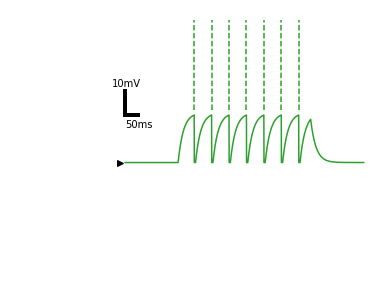

In [5]:
from model import Model
exc_neuron_params = built_up_neuron_params(Model, 'RecExc')
fig = current_pulse_sim({'amp':210, 'delay':200, 'duration':500, 'color':Green},params=exc_neuron_params)

#### Inhibitory cells

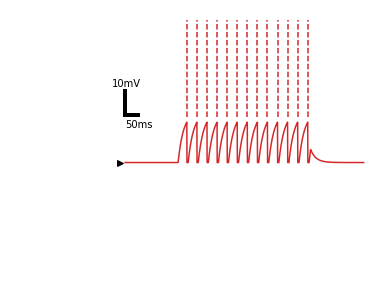

In [6]:
inh_neuron_params = built_up_neuron_params(Model, 'RecInh')
fig = current_pulse_sim({'amp':210, 'delay':200, 'duration':500, 'color':Red}, params=inh_neuron_params);

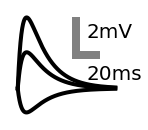

In [7]:
#########################################################
####### PSP associated to each synaptic connection ######
#########################################################

def psp(Model, nrn_pre, nrn_post, Ts, Erev, dt=0.1, t0=10, tstop=100):
    Cm, Gl, El = Model[nrn_post+'_Cm'], Model[nrn_post+'_Gl'], Model[nrn_post+'_El']
    t = np.arange(int(tstop/dt))*dt
    Q = Model['Q_'+nrn_pre+'_'+nrn_post]
    g = np.array([Q*np.exp(-tt/Ts) if tt>0 else 0 for tt in t])
    v = [El]
    for i in range(1, len(t)):
        v.append(v[i-1]+dt/Cm*(g[i]*(Erev-v[i-1])+Gl*(El-v[i-1])))
    return t, np.array(v)

plt.figure(figsize=(2,2))
for i, presyn, Erev in zip(range(3), ['AffExc', 'RecExc', 'RecInh'], [0, 0, -80]):
    plt.plot(*psp(Model, presyn, 'RecExc', 5, Erev), 'k-', lw=4)
plt.plot([60,60], [-68,-66], lw=8, color='grey')
plt.annotate("2mV", (70, -67), fontsize=20)
plt.plot([60,80], [-68,-68], lw=8, color='grey')
plt.annotate("20ms", (70, -69.5), fontsize=20)
set_plot(plt.gca(), [], xticks=[], yticks=[])

# A spectrum of asynchronous dynamics in recurrent networks

### Varying afferent excitation in a recurrent network 

#### Perform numerical simulations

In [13]:
import os
from model import pass_arguments_of_new_model, Model

def my_logspace(x1, x2, n):
    return np.logspace(np.log(x1)/np.log(10), np.log(x2)/np.log(10), n)

############################
##### Numerical simulation
Model2 = Model.copy()
Model2['dt'], Model2['tstop'] = 0.1, 2000.
tf_file = 'sparse_vs_balanced/varying_AffExc.py'
S = ''
S += 'python '+tf_file+pass_arguments_of_new_model(Model2)
S += ' --F_AffExc_array'
for fa in my_logspace(3., 25, 30): S += ' '+str(fa)
S += ' --SEEDS'
for s in np.arange(10): S += ' '+str(s)
S += ' -df sparse_vs_balanced/data'+os.path.sep
S += ' -f sparse_vs_balanced/data/varying_AffExc.zip \n'
bash_file = open('sparse_vs_balanced/bash_scan/dep_AffExc_scan.sh', 'w')
bash_file.write(S);bash_file.close()

############################
##### Analysis
S = 'python '+tf_file+' -a -f sparse_vs_balanced/data/varying_AffExc.zip \n'
bash_file = open('sparse_vs_balanced/bash_scan/analysis_dep_AffExc_scan.sh', 'w')
bash_file.write(S);bash_file.close()

## Workflow:


- execute the script that runs the numerical simulation: *sparse_vs_balanced/bash_scan/dep_AffExc_scan.sh* (good to do this on a sever)
- execute the analysis script: *sparse_vs_balanced/bash_scan/analysis_dep_AffExc_scan.sh* (good to do this on a sever)
- get the raw data file: *sparse_vs_balanced/data/varying_AffExc.zip*, this is a big zip files with all the hdf5 files that corresponds to each scan
- get the analyzed file: *sparse_vs_balanced/data/varying_AffExc_analyzed.npy*, this is a light weight file, easy to manipulate

#### Loading raw data

In [14]:
### to look up at specific configurations, we load all the data (long)
from sparse_vs_balanced.varying_AffExc import get_scan
Model, F_aff, seeds, DATA = get_scan({}, filename='sparse_vs_balanced/data/varying_AffExc.zip')

#### Data analysis

In [10]:
# this file contains the analysis to quantify regime-specificity
from sparse_vs_balanced.plot_state_signature import plot_act_vs_aff_level

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


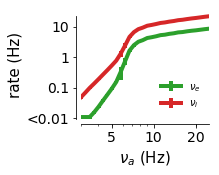

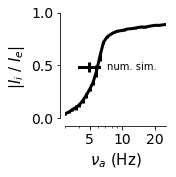

In [11]:
"""
Plotting: varying Afferent Excitation
"""
%matplotlib inline
fig1, fig2 = plot_act_vs_aff_level('sparse_vs_balanced/data/varying_AffExc_analyzed.npy')

## Analysis of the synchrony of network activity

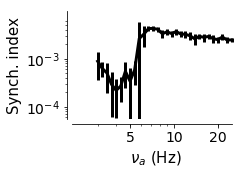

In [15]:
"""
Computing synchrony
"""
FA, SYNCH, _, _, EXC_ACT, INH_ACT, _, _, _ = np.load('sparse_vs_balanced/data/varying_AffExc_analyzed.npy')
Synch, sSynch, Fe, Fi = [], [], [], []
Fa = np.unique(np.unique(FA))
for fa in Fa:
    i0 = np.argwhere(np.array(FA)==fa)
    Synch.append(np.abs(SYNCH[i0]).mean())
    Fe.append(EXC_ACT[i0].mean())
    Fi.append(INH_ACT[i0].mean())
    sSynch.append(np.abs(SYNCH[i0]).std())
XTICKS=[2,5,10,20]
fig3, ax3 = plt.subplots(1, figsize=(3,2))
ax3.errorbar(Fa, Synch, sSynch, lw=3, color='k')
ax3.set_xscale('log');ax3.set_yscale('log')
set_plot(ax3,
         ylabel='Synch. index', xlabel='$\\nu_a$ (Hz)',
         xticks=XTICKS, yticks=[1e-4, 1e-3, 1e-2],
         xticks_labels=[str(x) for x in XTICKS])
np.save('sparse_vs_balanced/data/varying_AffExc_analyzed2.npy', [np.unique(np.unique(FA)), Synch, sSynch, Fe, Fi])

### First, let's compare the magnitude of the synchrony index with other regimes

#### Numerical simulations of synchronized activity

In [15]:
"""
Example 1 : Synchronous Regular activity (saturated regime  -- epilepsy like)

---------> achieved by potentiating recurrent excitation !
"""
from model import Model
from sparse_vs_balanced.running_2pop_model import run_2pop_ntwk_model
SR_Model = Model.copy()
SR_Model['Q_RecExc_RecExc'], SR_Model['Q_RecInh_RecExc'] = 8., 8. # multiplying excitatory weights by a factor 4
SR_Model['F_AffExc'] = 7. # no need of high input
run_2pop_ntwk_model(SR_Model, filename='sparse_vs_balanced/data/SR.h5', with_Vm=4, tstop=1000.);

In [64]:
"""
Example 2 : Synchronous Irregular activity (  -- gamma-like)

---------> achieved by potentiating recurrent synapses and a high input !
       we adapt our parameters to reach a configuration 
       somehow similar to Figure 2A in Kumar et al. 2008, Neural Computation
"""
from model import Model
SI_Model = Model.copy()
SI_Model['RecInh_Vthre'] = -50 # symmetric inhibition
SI_Model['Q_RecInh_RecExc'], SI_Model['Q_RecInh_RecInh'] = 30., 30. # raising inh weights
SI_Model['Q_RecExc_RecExc'], SI_Model['Q_RecExc_RecInh'] = 3., 3.  # raising exc weights
SI_Model['Q_AffExc_RecExc'], SI_Model['Q_AffExc_RecInh'] = 2., 2.  # reducing aff weights
SI_Model['p_RecExc_RecExc'], SI_Model['p_RecExc_RecInh'] = 0.2, 0.2 # raising connectivity
SI_Model['p_RecInh_RecExc'], SI_Model['p_RecInh_RecInh'] = 0.2, 0.2 # raising connectivity
SI_Model['F_AffExc'] = 200. # high input
run_2pop_ntwk_model(SI_Model, filename='sparse_vs_balanced/data/SI.h5', with_Vm=4, tstop=1000.);

#### Analysis of synchronized activity

Synchrony index of Synchronous Regular activity: 0.96588973448


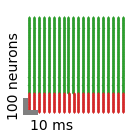

In [16]:
# analysis of synchronous regular (SR) state
from sparse_vs_balanced.plot_state_signature import raster_plot
from data_analysis.IO.hdf5 import load_dict_from_hdf5
SR_data = load_dict_from_hdf5('sparse_vs_balanced/data/SR.h5')
# fig, AX = plt.subplots(1, 3, figsize=(8,2.5));plt.subplots_adjust(wspace=.2)
fig = raster_plot(SR_data, tzoom=[800, 900], Nmax=800, Tbar=10, Nbar=100)
# now get the synchrony index
from neural_network_dynamics.analysis.macro_quantities import get_synchrony_of_spiking
SR_synch_index = get_synchrony_of_spiking(SR_data, pop='RecExc')
print('Synchrony index of Synchronous Regular activity:', SR_synch_index)

Synchrony index of Synchronous Irregular activity: 0.0247454664965


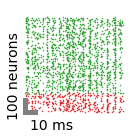

In [17]:
# analysis of synchronous irregular (SI) state
SI_data = load_dict_from_hdf5('sparse_vs_balanced/data/SI.h5')
fig = raster_plot(SI_data, tzoom=[900, 1000], Nmax=800, Tbar=10, Nbar=100)
# now get the synchrony index
SI_synch_index = get_synchrony_of_spiking(SI_data, pop='RecExc')
print('Synchrony index of Synchronous Irregular activity:', SI_synch_index)

#### So we put this synchrony in perspective:

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


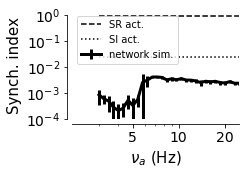

In [18]:
fig, ax = plt.subplots(1, figsize=(3,2))
ax.errorbar(Fa, Synch, sSynch, lw=3, color='k', label='network sim.')
ax.set_xscale('log');ax.set_yscale('log')
SR_synch_index=0.97;ax.plot(Fa, SR_synch_index+0.*Fa, 'k--', label='SR act.')
SI_synch_index=0.025;ax.plot(Fa, SI_synch_index+0.*Fa, 'k:', label='SI act.')
ax.legend()
set_plot(ax,
         ylabel='Synch. index', xlabel='$\\nu_a$ (Hz)',
         xticks=XTICKS, xticks_labels=[str(x) for x in XTICKS],
         yticks=[1e-4, 1e-3, 1e-2, 1e-1, 1], xlim=[Fa.min(), Fa.max()])

### Let's compare the network synchrony with those of independent Poisson processes (finite number) 

In [20]:
def generate_discrete_Poisson_process(freq, dt, N, tstop):
    indices, times = [], []
    # trivial way to generate homogeneous poisson events
    for it in range(int(tstop/dt)):
        rdm_num = np.random.random(N)
        for ii in np.arange(N)[rdm_num<dt*freq*1e-3]:
            indices.append(ii) # all the indices
            times.append(it*dt) # all the same time !
    return np.array(indices), np.array(times)

In [22]:
from neural_network_dynamics.analysis.macro_quantities import get_synchrony_of_spiking
# loading the parameters of the simulation !
data = dict(np.load('sparse_vs_balanced/data/varying_AffExc_Model.npz').items())
data2 = data.copy()
data2['tstop'] = [data['tstop']]
data2['0'] = {'N':data['N_RecExc'], 'name':'RecExc'}
data2['1'] = {'N':data['N_RecInh'], 'name':'RecInh'}
# laoding the output of the network numerical simulations
Fa, Synch, sSynch, Fe, Fi = np.load('sparse_vs_balanced/data/varying_AffExc_analyzed2.npy')
indep_Synch, indep_sSynch = 0*Synch, 0*sSynch
for i in range(len(Fa)):
    # loop over afferent levels
    SYNCH = []
    for n in data['SEEDS']:
        data2['iRASTER_RecExc'], data2['tRASTER_RecExc'] =\
            generate_discrete_Poisson_process(Fe[i], data['dt'], data['N_RecExc'], data['tstop'])
        data2['iRASTER_RecInh'], data2['tRASTER_RecInh'] =\
            generate_discrete_Poisson_process(Fi[i], data['dt'], data['N_RecInh'], data['tstop'])
        s = .2*get_synchrony_of_spiking(data2, pop='RecInh')+.8*get_synchrony_of_spiking(data2, pop='RecExc')
        SYNCH.append(s)
    indep_Synch[i], indep_sSynch[i] = np.array(np.abs(SYNCH)).mean(), np.array(np.abs(SYNCH)).std()        

In [ ]:
fig, ax = plt.subplots(1, figsize=(3,2))
ax.errorbar(Fa, Synch, sSynch, lw=3, color='k', label='network sim.')
ax.errorbar(Fa, indep_Synch, indep_sSynch, lw=3, color=Brown, label='Poisson sim.')
ax.set_xscale('log')
ax.legend()
set_plot(ax, xlim=[Fa.min(), Fa.max()],
         ylabel='Synch. index', xlabel='$\\nu_a$ (Hz)',
         yticks=[0, 0.003, 0.006],
         xticks=XTICKS, xticks_labels=[str(x) for x in XTICKS])

## Looking at two regimes withing the spectrum

In [30]:
"""
Example 1 : Sparse Activity (running simulation and saving)
"""
# function to run the two population model
from sparse_vs_balanced.running_2pop_model import run_2pop_ntwk_model
from model import Model
SA_Model = Model.copy()
SA_Model['F_AffExc'], SA_Model['F_DsInh'] = 4.5, 0.
run_2pop_ntwk_model(SA_Model, filename='sparse_vs_balanced/data/sas.h5', with_Vm=10, tstop=10000.);

In [31]:
"""
Example 2 : Balanced Activity (running simulation and saving)
"""
# function to run the two population model
from sparse_vs_balanced.running_2pop_model import run_2pop_ntwk_model
from model import Model
BS_Model = Model.copy()
BS_Model['F_AffExc'], BS_Model['F_DsInh'] = 20., 0.
run_2pop_ntwk_model(BS_Model, filename='sparse_vs_balanced/data/bs.h5', with_Vm=10, tstop=10000.);

## Comparing the two regimes

In [32]:
# loading the data of the previous two numerical simulations
from data_analysis.IO.hdf5 import load_dict_from_hdf5
sas_data = load_dict_from_hdf5('sparse_vs_balanced/data/sas.h5')
bs_data = load_dict_from_hdf5('sparse_vs_balanced/data/bs.h5')

The data analysis code for the state signature is in:

*./sparse_vs_balanced/plot_state_signature.py*


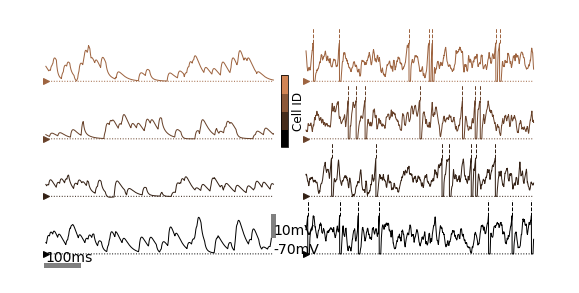

In [33]:
"""
Show membrane potential traces
"""
from sparse_vs_balanced.plot_state_signature import few_Vm_fig
fig = few_Vm_fig([sas_data,bs_data], pop_key='RecExc',
                 tzoom=[1000,1700],
                 VMS1=np.arange(4),
                 tspace=100)

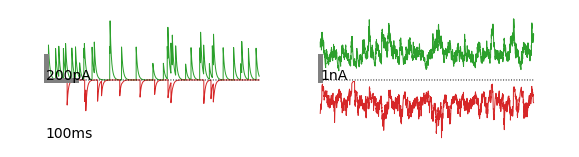

In [39]:
"""
Show the traces of excitatory and inhibitory synaptic currents
"""
from sparse_vs_balanced.plot_state_signature import Isyn_fig
fig = Isyn_fig([sas_data, bs_data],
               tzoom=[1000,1700],
               VMS1=1, VMS2=0)

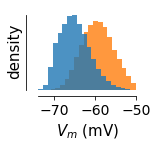

In [34]:
"""
Show membrane potential distributions
"""
from sparse_vs_balanced.plot_state_signature import Vm_histograms
fig = Vm_histograms([bs_data, sas_data], tspkdiscard=20.)

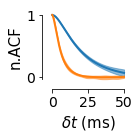

In [35]:
"""
Show membrane potential distributions
"""
from sparse_vs_balanced.plot_state_signature import Vm_autocorrel
fig = Vm_autocorrel([sas_data, bs_data])

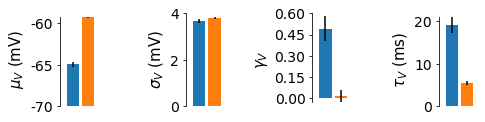

In [36]:
"""
Showing the signature in terms of membrane potential fluctuations:
1) mean 
2) standard deviation
3) skewness
4) autocorrelation time
"""
from sparse_vs_balanced.plot_state_signature import Vm_signature
fig = Vm_signature([sas_data, bs_data])

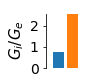

In [37]:
"""
Showing the excitatory and inhibitory conductances in the two regimes
"""
from sparse_vs_balanced.plot_state_signature import conductances_ratio
fig = conductances_ratio([sas_data, bs_data])

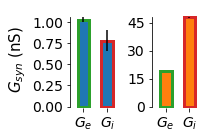

In [38]:
from sparse_vs_balanced.plot_state_signature import conductances
fig = conductances([sas_data, bs_data])

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


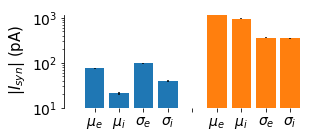

In [40]:
"""
Showing the excitatory and inhibitory currents in the two regimes
"""
from sparse_vs_balanced.plot_state_signature import currents
fig = currents([sas_data, bs_data])

# Dependency on cellular and network parameters

In [43]:
################################################################
##### Constructing simulations for parameter variations ########
################################################################
from sparse_vs_balanced.params_scan import write_bash_scripts, run_one_config_of_dep_on_ExcAff, my_logspace
################################################################
## plotting how the relationship to afferent activity is affected
####      by a specific parameter
################################################################
from sparse_vs_balanced.params_scan import plot_effect_of_params
################################################################
##### visualizing the dynamics of a specific set of parameters #
# RASTER PLOT + 4 VMS SAMPLES (3Exc+1Inh) + 1 SYN. CURRENTS SAMPLE #
#################################################################
from sparse_vs_balanced.params_scan import look_at_specific_realisation

### Varying the strength of the excitatory afferent synapse

In [50]:
# factor with which we multiply the default weights
QA_VALUES = [1., 2., 3., 4., 5.] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for q in QA_VALUES:
    FILENAMES.append('dAE_QaValues_'+str(q)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string,
    Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'Q_AffExc_RecExc':q,
                                         'Q_AffExc_RecInh':q},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
    
    
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
                   'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_Qa.sh')

In [54]:
print('List of analyzed datafiles:')
print(Fetch_analysis_string.replace('sget', '-> '))

List of analyzed datafiles:
->  sparse_vs_balanced/data/dAE_QaValues_1.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QaValues_2.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QaValues_3.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QaValues_4.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QaValues_5.0_analyzed.npy 



### Workflow:


- execute the script that runs the numerical simulation: *sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_Qa.sh* (good to do this on a sever)
- execute the analysis script: *sparse_vs_balanced/bash_scan/analysis_dep_AffExc_scan_varying_Qa.sh* (good to do this on a sever)
- get the raw data file: *sparse_vs_balanced/data/varying_AffExc.zip*, this is a big zip files with all the hdf5 files that corresponds to each scan
- get the above list of analyzed file, this is what will be actually plotted in the following

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


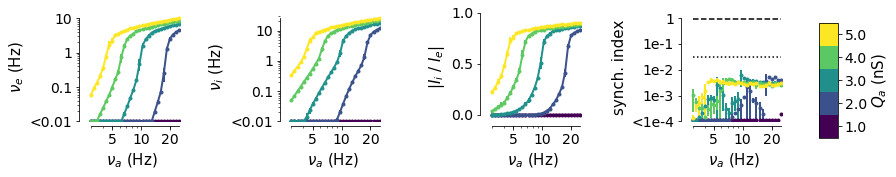

In [59]:
fig = plot_effect_of_params(QA_VALUES,
                            'sparse_vs_balanced/data/dAE_QaValues_',
                            '$Q_a$ (nS)')

### Varying the strength of recurrent synaptic weights

In [60]:
# factor with which we multiply the default weights
Q_FACTOR = [0.2, 0.5, 1., 2., 5.] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for q in Q_FACTOR:
    FILENAMES.append('dAE_Qfactor_'+str(q)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'Q_RecExc_RecExc':Model['Q_RecExc_RecExc']*q,
                                          'Q_RecExc_RecInh':Model['Q_RecExc_RecInh']*q,\
                                          'Q_RecInh_RecExc':Model['Q_RecInh_RecExc']*q,
                                          'Q_RecInh_RecInh':Model['Q_RecInh_RecInh']*q},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
                   'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_Q_both.sh')

In [61]:
print('List of analyzed datafiles:')
print(Fetch_analysis_string.replace('sget', '-> '))

List of analyzed datafiles:
->  sparse_vs_balanced/data/dAE_Qfactor_0.2_analyzed.npy 
->  sparse_vs_balanced/data/dAE_Qfactor_0.5_analyzed.npy 
->  sparse_vs_balanced/data/dAE_Qfactor_1.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_Qfactor_2.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_Qfactor_5.0_analyzed.npy 



WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


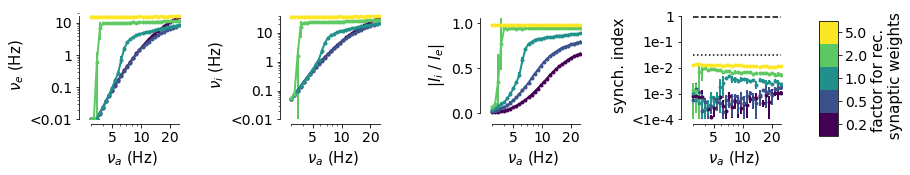

In [62]:
fig = plot_effect_of_params(Q_FACTOR,
                            'sparse_vs_balanced/data/dAE_Qfactor_',
                            'factor for rec. \n synaptic weights')

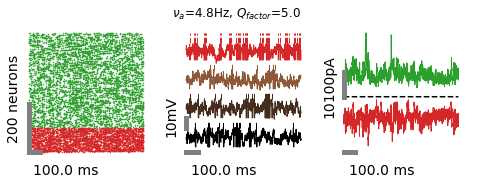

In [41]:
# if you have the zip datafiles here
# you can have a look at a specific realistions through:
look_at_specific_realisation(Q_FACTOR, 4, 
         'sparse_vs_balanced/data/dAE_Qfactor_', label='$Q_{factor}$',
          Faff=5, Tbar=100., Nmax=500)

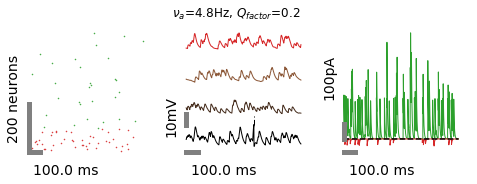

In [40]:
look_at_specific_realisation(Q_FACTOR, 0,
        'sparse_vs_balanced/data/dAE_Qfactor_', label='$Q_{factor}$',
        Faff=5, Tbar=100., Nmax=500)

### Varying the strength of the recurrent excitatory synapse only

In [63]:
# factor with which we multiply the default weights
QE_VALUES = [0.5, 1., 2., 4.] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for q in QE_VALUES:
    FILENAMES.append('dAE_QeValues_'+str(q)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'Q_RecExc_RecExc':q,
                                         'Q_RecExc_RecInh':q},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
                   'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_Qe.sh')

In [64]:
print('List of analyzed datafiles:')
print(Fetch_analysis_string.replace('sget', '-> '))

List of analyzed datafiles:
->  sparse_vs_balanced/data/dAE_QeValues_0.5_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QeValues_1.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QeValues_2.0_analyzed.npy 
->  sparse_vs_balanced/data/dAE_QeValues_4.0_analyzed.npy 



In [ ]:
fig = plot_effect_of_params(QE_VALUES,
                            'sparse_vs_balanced/data/dAE_QeValues_',
                            '$Q_e$ (nS)')

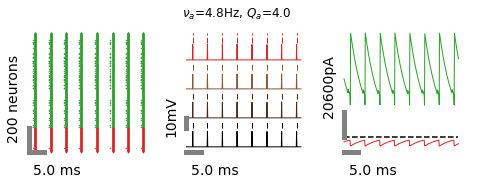

In [25]:
look_at_specific_realisation(QE_VALUES, 3, 
                             'sparse_vs_balanced/data/dAE_QeValues_', 
                             Faff=5., Tbar=5., tzoom=[1000,1040])

### Varying the strength of the inhibitory recurrent synapse only

In [67]:
# factor with which we multiply the default weights
QI_VALUES = [5., 15., 20., 30., 40.] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for q in QI_VALUES:
    FILENAMES.append('dAE_QiValues_'+str(q)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'Q_RecInh_RecExc':q,
                                          'Q_RecInh_RecInh':q},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
                   'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_Qi.sh')

In [ ]:
fig = plot_effect_of_params(QI_VALUES, 'sparse_vs_balanced/data/dAE_QiValues_', '$Q_i$ (nS)',\
                            yticks=[0.01, 0.1, 1., 10.,100.], yticks_labels=['<0.01', '0.1', '1', '10', '100'])

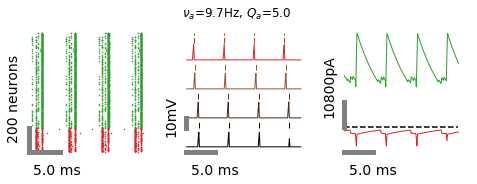

In [28]:
look_at_specific_realisation(QI_VALUES, 0, 
                             'sparse_vs_balanced/data/dAE_QiValues_', 
                             Faff=10, Tbar=5., tzoom=[1000,1020])

### Varying recurrent connectivity

In [74]:
# probability of pairwise connections:
P_CONN = [0.02, 0.05, 0.1, 0.2, 0.5] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for p in P_CONN:
    FILENAMES.append('dAE_pconn_'+str(p)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'p_RecExc_RecExc':p,
                                         'p_RecExc_RecInh':p,
                                         'p_RecInh_RecExc':p,
                                         'p_RecInh_RecInh':p},
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
      'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_pconn.sh')

In [ ]:
fig = plot_effect_of_params(P_CONN, 'sparse_vs_balanced/data/dAE_pconn_', 'recurrent \n conn. proba.')

### Varying the size of the network

In [75]:
N_FACTOR = [0.5, 1, 2, 4, 8] # chosen values to investigate

from model import Model
FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for nf in N_FACTOR:
    FILENAMES.append('dAE_nfactor_'+str(nf)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({\
                                          'N_RecInh':int(nf*Model['N_RecInh']),\
                                          'N_RecExc':int(nf*Model['N_RecExc'])},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string, tstop=1000.)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
          'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_N.sh')

In [ ]:
fig = plot_effect_of_params(N_FACTOR, 
 'sparse_vs_balanced/data/dAE_nfactor_', 'number factor\n($N_{tot})$',
                            yticks=[0.01, 0.1, 1., 10.],
                            yticks_labels=['<0.01', '0.1', '1', '10'])

### Varying the size of the network while keeping the number of synapses (so just to reduce finite-size effects)

In [92]:
N_FACTOR = [0.5, 1, 2, 4, 8] # chosen values to investigate

from model import Model
FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string,\
          Fetch_analysis_string = '', '', '', ''
for nf in N_FACTOR:
    FILENAMES.append('dAE_n_pconn_factor_'+str(nf)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string,\
    Fetch_analysis_string = run_one_config_of_dep_on_ExcAff({\
                 'N_RecInh':int(nf*Model['N_RecInh']),
                 'N_RecExc':int(nf*Model['N_RecExc']),
                 'p_RecExc_RecExc':Model['p_RecExc_RecExc']/nf,
                 'p_RecExc_RecInh':Model['p_RecExc_RecInh']/nf,
                 'p_RecInh_RecExc':Model['p_RecInh_RecExc']/nf,
                 'p_RecInh_RecInh':Model['p_RecInh_RecInh']/nf},
                 filename=FILENAMES[-1],
                 Sim_string = Sim_string,
                 Analysis_string = Analysis_string,
                 Fetch_data_string = Fetch_data_string,
                 Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
  'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_N_and_pconn.sh')

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


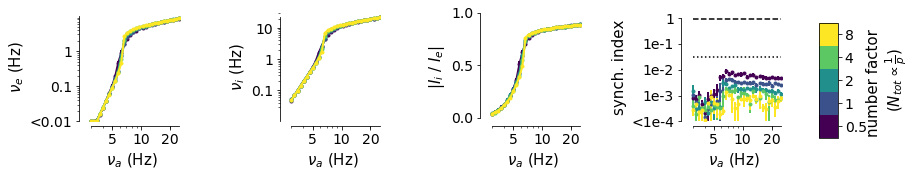

In [93]:
fig = plot_effect_of_params(N_FACTOR, 
                          'sparse_vs_balanced/data/dAE_n_pconn_factor_',
             'number factor \n'+r'$(N_{tot} \propto \frac{1}{p})$',
                            yticks=[0.01, 0.1, 1., 10.],
                            yticks_labels=['<0.01', '0.1', '1', '10'])

### Varying the excitability of the inhibitory cells

In [80]:
VTHRE = [-57, -53, -52, -51, -49] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for v in VTHRE:
    FILENAMES.append('dAE_vthreinh_'+str(v)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'RecInh_Vthre':v},\
                                        filename=FILENAMES[-1],
                                        Sim_string = Sim_string,
                                        Analysis_string = Analysis_string,
                                        Fetch_data_string = Fetch_data_string,
                                        Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
                   'sparse_vs_balanced/bash_scan/dep_AffExc_scan_varying_VthreInh.sh')

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


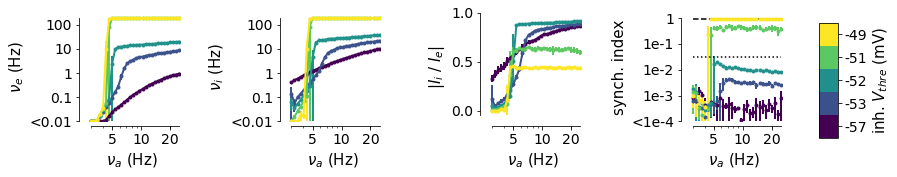

In [81]:
fig = plot_effect_of_params(VTHRE, 'sparse_vs_balanced/data/dAE_vthreinh_', 'inh. $V_{thre}$ (mV)',\
                            yticks=[0.01, 0.1, 1., 10.,100.], yticks_labels=['<0.01', '0.1', '1', '10', '100'])
fig.savefig(desktop+'temp.svg')

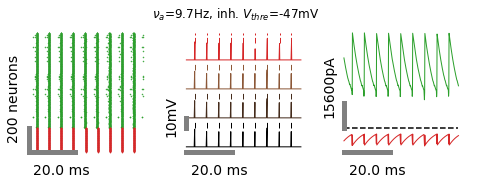

In [10]:
look_at_specific_realisation(VTHRE, 4, 
                             'sparse_vs_balanced/data/dAE_vthreinh_', label='inh. $V_{thre}$', unit='mV',
                             Faff=10, Tbar=20., tzoom=[1000,1050])

### Introducing a disinhibitory population (and varying its coupling to the afferent excitation)

In [96]:
DSNH_AFF_COUPLING = [0.01, 0.05, 0.075, 0.1] # chosen values to investigate

FILENAMES = []
Sim_string, Analysis_string, Fetch_data_string, Fetch_analysis_string = '', '', '', ''
for p in DSNH_AFF_COUPLING:
    FILENAMES.append('dAE_dsnh_aff_coupling_'+str(p)+'.zip')
    Sim_string, Analysis_string, Fetch_data_string,\
    Fetch_analysis_string = \
        run_one_config_of_dep_on_ExcAff({'p_AffExc_DsInh':p},\
                       filename=FILENAMES[-1],
                       Sim_string = Sim_string,
                       Analysis_string = Analysis_string,
                       Fetch_data_string = Fetch_data_string,
                       Fetch_analysis_string = Fetch_analysis_string)
# and we write the bash script that will run this parameters scan
write_bash_scripts(Sim_string, Analysis_string,
                   Fetch_data_string, Fetch_analysis_string,
    'sparse_vs_balanced/bash_scan/dsnh_loop_strength_scan.sh')

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


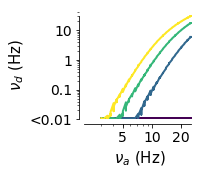

In [86]:
from matplotlib.cm import viridis
fig, ax = plt.subplots(1, figsize=(2, 2))
for i, c in enumerate(DSNH_AFF_COUPLING):
    Fa = np.load('sparse_vs_balanced/data/dAE_dsnh_aff_coupling_'+str(c)+'_analyzed.npy')[0]
    Fd = np.load('sparse_vs_balanced/data/dAE_dsnh_aff_coupling_'+str(c)+'_analyzed.npy')[8]
    Fd[Fd<0.01] = 0.011
    ax.plot(Fa, Fd, color=viridis(i/(len(DSNH_AFF_COUPLING)-1)), lw=2)
ax.set_xscale('log');ax.set_yscale('log')
set_plot(ax, xlabel='$\\nu_a$ (Hz)', ylabel='$\\nu_d$ (Hz)',
         xticks=[2,5,10,20], xticks_labels=['2', '5','10','20'],
         yticks=[0.01, 0.1, 1., 10.], yticks_labels=['<0.01', '0.1', '1', '10'])

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


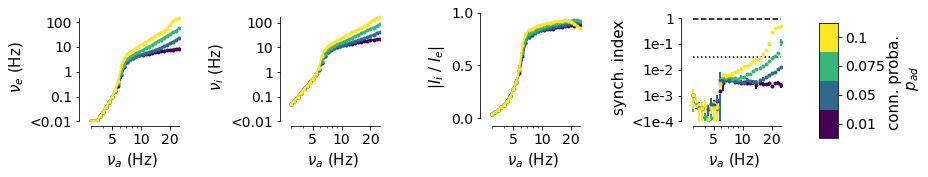

In [84]:
fig = plot_effect_of_params(DSNH_AFF_COUPLING, 'sparse_vs_balanced/data/dAE_dsnh_aff_coupling_',
                            'conn. proba. \n $p_{ad}$',\
                            yticks=[0.01, 0.1, 1., 10.,100.], yticks_labels=['<0.01', '0.1', '1', '10', '100'])
fig.savefig(desktop+'temp.svg')

WARNING    /Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
 [py.warnings]


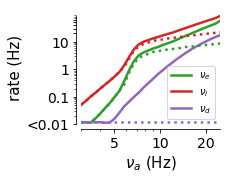

In [89]:
fig1, ax1 = plt.subplots(1, figsize=(2.5, 2.1))
DATA0 = np.load('sparse_vs_balanced/data/dAE_n_pconn_factor_1_analyzed.npy')
DATA1 = np.load('sparse_vs_balanced/data/dAE_dsnh_aff_coupling_0.075_analyzed.npy')
LW=2.5
for data, t in zip([DATA1, DATA0], ['-',':']):
    F_aff = np.unique(data[0])
    seeds = np.arange(int(len(data[0])/len(F_aff)))
    Fe = data[4].reshape((len(F_aff), len(seeds)))
    Fe[Fe<0.01] = 0.012
    ax1.plot(F_aff, Fe.mean(axis=1), t, color=Green, lw=LW, label='$\\nu_e$')
    Fi = data[5].reshape((len(F_aff), len(seeds)))
    Fi[Fi<0.01] = 0.012
    ax1.plot(F_aff, Fi.mean(axis=1), t, color=Red, lw=LW, label='$\\nu_i$')
    Fd = data[8].reshape((len(F_aff), len(seeds)))
    Fd[Fd<0.01] = 0.012
    ax1.plot(F_aff, Fd.mean(axis=1), t, color=Purple, lw=LW, label='$\\nu_d$')
    # Bal = data[3].reshape((len(F_aff), len(seeds)))
    # ax2.plot(F_aff, Bal.mean(axis=1), t, color='k', lw=1, label=label)
ax1.set_xscale('log');ax1.set_yscale('log')
set_plot(ax1, xlabel='$\\nu_a$ (Hz)', ylabel='rate (Hz)',
         xticks=[2,5,10,20], xticks_labels=['2', '5','10','20'],
         yticks=[0.01, 0.1, 1., 10., 20., 30., 40., 50., 60.],
         yticks_labels=['<0.01', '0.1', '1', '10', '', '', '', '', ''])
ax1.set_xlim([F_aff.min(), F_aff.max()])
ax1.legend();

# Effect of a time varying afferent excitation

The rest of Figure 3 can be found in the form of a demo file in:

https://github.com/yzerlaut/notebook_papers/blob/master/sparse_vs_balanced/demo_Fig3.py

producing:

![Figure 3](sparse_vs_balanced/demo_Fig3.png)

In [99]:
from sparse_vs_balanced.effect_of_strong_afferent import get_scan
Model, seeds, DATA = get_scan({}, filename='sparse_vs_balanced/data/time_varying_input.zip')

(-0.1, 9)

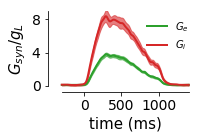

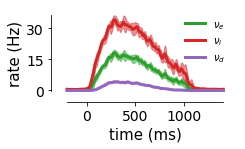

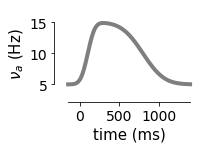

In [19]:
from sparse_vs_balanced.effect_of_strong_afferent import get_scan, one_Vm_fig
fig = one_Vm_fig(DATA[0], Model, XTICKS=[0, 500, 1000], FIGSIZE=(6,4.5), t0=550,
                 iNVm_Inh=1, iNVm_DsInh=0, iNVm_Exc=[1, 3, 4])
fig.savefig(desktop+'temp.svg')

In [3]:
from sparse_vs_balanced.effect_of_strong_afferent import hist_of_Vm_pre_post, get_scan
Model, seeds, DATA = get_scan({}, filename='sparse_vs_balanced/data/time_varying_input.zip')
fig, [std_stim, std_pre] = hist_of_Vm_pre_post(DATA, Model, nbin=18, tstart=200, tdur=400, FIGSIZE=(2.2,2.2));
fig.savefig(desktop+'temp.svg')

In [24]:
fig, ax = plt.subplots(figsize=(0.6,1.3))
plt.bar([0], [std_pre], color=Blue)
plt.bar([1], [std_stim], color=Orange)
set_plot(ax, ['left'], xticks=[], yticks=[0,2,4], ylabel='$\sigma_V$ (mV)')
fig.savefig(desktop+'temp.svg')

# Response to time varying envelopes

In [31]:
from model import pass_arguments_of_new_model, Model
import os
def build_varying_envelope_scan(faff_bsl, faff0, faff1, discretization, Nseed, filename):
    from model import pass_arguments_of_new_model, Model
    Model2 = Model.copy()
    Model2['p_AffExc_DsInh'] = 0.075
    Model2['tstop'] = 2000.
    S = 'python sparse_vs_balanced/varying_rate_envelope.py '+pass_arguments_of_new_model(Model2)
    S += ' --SEEDS'
    for s in np.arange(1, Nseed+1): S += ' '+str(s)
    S += ' --faff_bsl '+str(faff_bsl)
    S += ' --faff0 '+str(faff0)
    S += ' --faff1 '+str(faff1)
    S += ' -N '+str(discretization)
    S += ' -f sparse_vs_balanced/data'+os.path.sep+filename+' & \n'
    print('sget sparse_vs_balanced/data'+os.path.sep+filename)
    return S
S1 = build_varying_envelope_scan(4., 0.1, 7, 10, 10, 'varying_rate_envelopes_SA.zip')    
S2 = build_varying_envelope_scan(14., 0.1, 7, 10, 10, 'varying_rate_envelopes_BA.zip')    
bash_file = open('sparse_vs_balanced/bash_scan/various_rate_envelopes.sh', 'w')
bash_file.write(S1+S2)
bash_file.close()

sget sparse_vs_balanced/data/varying_rate_envelopes_SA.zip
sget sparse_vs_balanced/data/varying_rate_envelopes_BA.zip


In [86]:
from sparse_vs_balanced.varying_rate_envelope import get_scan, make_single_resp_fig

F_aff, seeds, _, DATA_SA = get_scan({}, filename='sparse_vs_balanced/data/varying_rate_envelopes_SA.zip')
F_aff, seeds, Model, DATA_BA = get_scan({}, filename='sparse_vs_balanced/data/varying_rate_envelopes_BA.zip')    

In [87]:
from data_analysis.processing.signanalysis import gaussian_smoothing
import matplotlib.cm as cm
from graphs.my_graph import *
def make_single_resp_fig(F_aff, seeds, Model, DATA_SA, DATA_BA,
                         smoothing = 30, t0 = 430, XTICKS=np.arange(4)*250,
                         tstart_vis = 350, tend_vis=700, t_after_stim_for_bsl=1400.):
    
    fig1, ax1 = plt.subplots(1, figsize=(4,2.5))
    plt.subplots_adjust(left=.3, bottom=.4)
    fig2, ax2 = plt.subplots(1, figsize=(4,2.5))
    plt.subplots_adjust(left=.3, bottom=.4)
    fig3, ax3 = plt.subplots(1, figsize=(4,2.5))
    plt.subplots_adjust(left=.3, bottom=.4)

    for i in range(len(F_aff)):
        SA_TRACES, BA_TRACES = [], []
        for j in range(len(seeds)):
            data = DATA_SA[i*len(seeds)+j]
            v = gaussian_smoothing(data['POP_ACT_RecExc'],int(smoothing/Model['dt']))
            SA_TRACES.append(v)
            data = DATA_BA[i*len(seeds)+j]
            v = gaussian_smoothing(data['POP_ACT_RecExc'],int(smoothing/Model['dt']))
            BA_TRACES.append(v)
        SA_mean, SA_std = np.array(SA_TRACES).mean(axis=0), np.array(SA_TRACES).std(axis=0)
        BA_mean, BA_std = np.array(BA_TRACES).mean(axis=0), np.array(BA_TRACES).std(axis=0)
        data = DATA_SA[i*len(seeds)+j]
        cond, cond2 = (data['t']>tstart_vis) & (data['t']<tend_vis) ,data['t']>t_after_stim_for_bsl
        ax2.plot(data['t'][cond]-t0,
                 SA_mean[cond]-SA_mean[cond2].mean(), color=cm.viridis(i/len(F_aff)), lw=2)
        ax2.fill_between(data['t'][cond]-t0,
                         SA_mean[cond]-SA_std[cond]-SA_mean[cond2].mean(),
                         SA_mean[cond]+SA_std[cond]-SA_mean[cond2].mean(),
                         color=cm.viridis(i/len(F_aff)), alpha=.5)
        ax3.plot(data['t'][cond]-t0,
                 BA_mean[cond]-BA_mean[cond2].mean(), color=cm.viridis(i/len(F_aff)), lw=2)
        ax3.fill_between(data['t'][cond]-t0,
                         BA_mean[cond]-BA_std[cond]-BA_mean[cond2].mean(),
                         BA_mean[cond]+BA_std[cond]-BA_mean[cond2].mean(),
                         color=cm.viridis(i/len(F_aff)), alpha=.5)
        ax1.plot(data['t'][cond]-t0,
                 data['faff'][cond]-data['faff'][cond2].mean(), color=cm.viridis(i/len(F_aff)), lw=3)
    set_plot(ax1, xlabel='time (ms)', ylabel='$\delta \\nu_a$  (Hz)', xticks=XTICKS, yticks=[0,3,6])
    set_plot(ax2, xlabel='time (ms)', ylabel='$\delta \\nu_e$ (Hz)', xticks=XTICKS, yticks=[0,4,8])
    set_plot(ax3, xlabel='time (ms)', ylabel='$\delta \\nu_e$ (Hz)', xticks=XTICKS, yticks=[0,12,24])
    return fig1, fig2, fig3
fig1, fig2, fig3 = make_single_resp_fig(F_aff[1::2], seeds, Model, DATA_SA[1::2], DATA_BA[1::2],
                                        smoothing = 30, t0 = 300, XTICKS=np.arange(3)*500,
                                        t_after_stim_for_bsl=1600.,
                                        tstart_vis = 100, tend_vis=1700);

In [41]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig1, fig2, fig3], fig_name=desktop+'temp.svg')

In [91]:
t0 = 300
window = [150, 500] # decoding window


SA_RATE, BA_RATE = np.zeros((len(F_aff), len(seeds))), np.zeros((len(F_aff), len(seeds)))
for i in range(len(F_aff)):
    for j in range(len(seeds)):
        data = DATA_SA[i*len(seeds)+j]
        cond = (data['t']>t0+window[0]) & (data['t']<t0+window[1])
        cond2 = data['t']<250 # for baseline activity
        SA_RATE[i,j] = data['POP_ACT_RecExc'][cond].mean()-data['POP_ACT_RecExc'][cond2].mean()
        data = DATA_BA[i*len(seeds)+j]
        BA_RATE[i,j] = data['POP_ACT_RecExc'][cond].mean()-data['POP_ACT_RecExc'][cond2].mean()

# fig1, ax1 = plt.subplots(1, figsize=(4,2.5))
# plt.subplots_adjust(left=.3, bottom=.4)
# fig2, ax2 = plt.subplots(1, figsize=(4,2.5))
# plt.subplots_adjust(left=.3, bottom=.4)
# for i in range(len(F_aff)):
#     ax1.hist(SA_RATE[i,:], color=cm.copper(i/len(F_aff)))
#     ax2.hist(BA_RATE[i,:], color=cm.copper(i/len(F_aff)))
# set_plot(ax1, xlabel='$\delta \\nu_e$ (Hz)', ylabel='count', yticks=[])
# set_plot(ax2, xlabel='$\delta \\nu_e$ (Hz)', ylabel='count', yticks=[])
XLIM, YLIM = 5, 5
fig1, ax1 = plt.subplots(1, figsize=(2.1,3.))
plt.subplots_adjust(left=.3, bottom=.4)
for rate, color, label in zip([SA_RATE, BA_RATE], [Blue, Orange], ['SA', 'BA']):
    mean, std = rate.mean(axis=1), rate.std(axis=1)
    # ax1.fill_between(F_aff, mean-std, mean+std, color=color, alpha=.5)
    # ax1.plot(F_aff, mean, '-', lw=3, color=color, label=label)
    ax1.errorbar(F_aff, mean, std, color=color, lw=4, label=label)
# ax1.legend()
set_plot(ax1, ylabel=r'$\langle \delta \nu_e \rangle_{T}$ (Hz)',
         xlabel='$\delta \\nu_a$ (Hz)', xticks = [1, 4, 7], yticks=[0,10,20])
fig1.savefig(desktop+'temp.svg')

In [43]:
fig1, ax1 = plt.subplots(1, figsize=(4,3.))
plt.subplots_adjust(left=.3, bottom=.4)
Blue, Orange = '#1f77b4', '#ff7f0e'

ax1.errorbar(F_aff, SA_RATE.mean(axis=1), yerr=SA_RATE.std(axis=1), color=Orange, fmt='o')
ax1.errorbar(F_aff, BA_RATE.mean(axis=1), yerr=BA_RATE.std(axis=1), color=Blue, fmt='o')

set_plot(ax1, ylabel='$\delta \\nu_e$ (Hz)', xlabel='$\delta \\nu_a$ (Hz)')

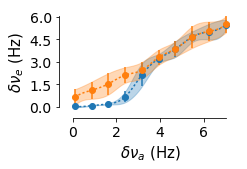

In [36]:
###################################
# making a quadratic interpolation
# of the mean and variance
###################################

from scipy.interpolate import interp1d
f_mean_sa = interp1d(F_aff, SA_RATE.mean(axis=1), kind='cubic')
f_std_sa = interp1d(F_aff, SA_RATE.std(axis=1), kind='cubic')
f_mean_ba = interp1d(F_aff, BA_RATE.mean(axis=1), kind='cubic')
f_std_ba = interp1d(F_aff, BA_RATE.std(axis=1), kind='cubic')
F_aff_HD = np.linspace(F_aff.min(), F_aff.max(), 100)

fig1, ax1 = plt.subplots(1, figsize=(4,3.))
plt.subplots_adjust(left=.3, bottom=.4)
ax1.errorbar(F_aff, SA_RATE.mean(axis=1), yerr=SA_RATE.std(axis=1), color=Blue, fmt='o')
ax1.plot(F_aff_HD, f_mean_sa(F_aff_HD), ':', color=Blue)
ax1.fill_between(F_aff_HD,
                 f_mean_sa(F_aff_HD)-f_std_sa(F_aff_HD),f_mean_sa(F_aff_HD)+f_std_sa(F_aff_HD),
                 alpha=.3, color=Blue)
ax1.errorbar(F_aff, BA_RATE.mean(axis=1), yerr=BA_RATE.std(axis=1), color=Orange, fmt='o')
ax1.plot(F_aff_HD, f_mean_ba(F_aff_HD), ':', color=Orange)
ax1.fill_between(F_aff_HD,
                 f_mean_ba(F_aff_HD)-f_std_ba(F_aff_HD),f_mean_ba(F_aff_HD)+f_std_ba(F_aff_HD),
                 alpha=.3, color=Orange)
set_plot(ax1, ylabel='$\delta \\nu_e$ (Hz)', xlabel='$\delta \\nu_a$ (Hz)')

In [37]:
###################################
# Computing Fisher information
###################################

def Fisher_Information(S, MEAN_FUNC, STD_FUNC):
    """
    Computes the Fisher information given a set of gaussian observations

    those observations are described by two functions of the stimulus
    value S, the mean MEAN_FUNC and standard deviation STD_FUNC
    """

    def gaussian_proba(r, mean, std):
        """ return the gaussian probability"""
        return np.exp(-(r-mean)**2/2./std**2)/np.sqrt(2.*np.pi)/std

    # we'll need a function that gives the simulus derivative
    # of the log of the conditional probability P(resp|stim)
    def deriv_log_pRS(r, s, ds=(S[1]-S[0])/10.):
        """ discrete derivation"""
        mean_minus, std_minus = MEAN_FUNC(s-ds), STD_FUNC(s-ds)
        mean_plus, std_plus = MEAN_FUNC(s+ds), STD_FUNC(s+ds)
        log_plus = np.log(gaussian_proba(r, mean_plus, std_plus))
        log_minus = np.log(gaussian_proba(r, mean_minus, std_minus))
        return (log_plus-log_minus)/ds
    
    Fisher_Info = 0.*S
    for i in range(1, len(S)-1):
        mean, std = MEAN_FUNC(S[i]), STD_FUNC(S[i])
        x_integral = np.linspace(mean-4*std, mean+4*std, 100) # integration space
        deriv_log_p = np.array([deriv_log_pRS(x, S[i]) for x in x_integral])
        proba = gaussian_proba(x_integral, mean, std)
        Fisher_Info[i] = np.trapz(proba*deriv_log_p**2, x_integral)
    return Fisher_Info    

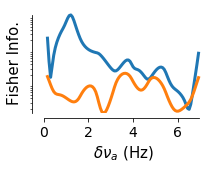

In [38]:
fig1, ax1 = plt.subplots(1, figsize=(4,3.))
plt.subplots_adjust(left=.3, bottom=.4)

ax1.plot(F_aff_HD[1:-1], Fisher_Information(F_aff_HD, f_mean_sa, f_std_sa)[1:-1], color=Blue, lw=3)
ax1.plot(F_aff_HD[1:-1], Fisher_Information(F_aff_HD, f_mean_ba, f_std_ba)[1:-1], color=Orange, lw=3)

plt.yscale('log')
set_plot(ax1, xlabel='$\delta \\nu_a$ (Hz)', ylabel='Fisher Info.', yticks=[]);

In [239]:
%matplotlib inline
from sparse_vs_balanced.varying_rate_envelope import analyze_scan
analyze_scan({}, filename='sparse_vs_balanced/data/varying_rate_envelopes_SA.zip')
analyze_scan({}, filename='sparse_vs_balanced/data/varying_rate_envelopes_BA.zip');

Done with analysis, now plotting and pdf export [...]
Done with analysis, now plotting and pdf export [...]


(<matplotlib.figure.Figure at 0x1116fb668>,
 <matplotlib.figure.Figure at 0x117ba1fd0>)

# Response to sparse spiking patterns

In [118]:
from model import pass_arguments_of_new_model, Model
import os
def build_varying_pattern_scan(faff_bsl, discretization, Nseed, filename):
    from model import pass_arguments_of_new_model, Model
    Model2 = Model.copy()
    Model2['p_AffExc_DsInh'] = 0.075
    S = 'python sparse_vs_balanced/sparse_spiking_input.py '+pass_arguments_of_new_model(Model2)
    S += ' --SEEDS'
    for s in np.arange(10, Nseed+10): S += ' '+str(s)
    S += ' --faff_bsl '+str(faff_bsl)
    S += ' -N '+str(discretization)
    S += ' -f sparse_vs_balanced/data'+os.path.sep+filename+' \n'
    print('sget sparse_vs_balanced/data'+os.path.sep+filename)
    return S
S1 = build_varying_pattern_scan(4., 10, 20, 'sparse_input_SA.zip')    
S2 = build_varying_pattern_scan(14., 10, 20, 'sparse_input_BA.zip')    
bash_file = open('sparse_vs_balanced/bash_scan/sparse_spiking.sh', 'w')
bash_file.write(S1+S2)
bash_file.close()

sget sparse_vs_balanced/data/sparse_input_SA.zip
sget sparse_vs_balanced/data/sparse_input_BA.zip


In [15]:
from sparse_vs_balanced.sparse_spiking_input import get_scan
from graphs.my_graph import *

t_pre, t_post = 100, 100 # we also considered 100 ms around the stim

Patterns, seeds, _, DATA_SA = get_scan({}, filename='sparse_vs_balanced/data/sparse_input_SA.zip')
F_aff, seeds, Model, DATA_BA = get_scan({}, filename='sparse_vs_balanced/data/sparse_input_BA.zip')

Ntraining = int(len(seeds)/3) # one third of the data

PRESYNAPTIC_PATTERNS_TRAINING = []
# each element will be a RASTER corresponding to one pattern and one seed !
SA_PATTERNS_TRAINING, BA_PATTERNS_TRAINING = [], []

PRESYNAPTIC_PATTERNS_TEST = []
# each element will be a RASTER corresponding to one pattern and one seed !
SA_PATTERNS_TEST, BA_PATTERNS_TEST = [], []

# we will also get the (trial-invariants) input patterns
PRESYNAPTIC_PATTERNS_RASTER = []

Ntest = len(seeds)-Ntraining # the rest of the data

for i in range(len(Patterns)):
    # TRAINING SET
    for j in range(Ntraining): # seeds only in the first training seet
        # first loop for training
        for DATA, PATTERNS in zip([DATA_SA, DATA_BA], [SA_PATTERNS_TRAINING, BA_PATTERNS_TRAINING]):
            data = DATA[i*len(seeds)+j]
            cond = (data['tRASTER_RecExc']>Model['t0']-t_pre) &\
                (data['iRASTER_RecExc']<int(Model['N_target'])) &\
                (data['tRASTER_RecExc']<Model['t0']+Model['time_span']+t_post)
            RASTER = []
            for ii in np.arange(int(Model['N_target'])):
                Nrn = []
                i0 = np.argwhere(data['iRASTER_RecExc'][cond]==ii).flatten()
                Nrn += list(data['tRASTER_RecExc'][cond][i0].flatten())
                RASTER.append(Nrn)
            PATTERNS.append(RASTER)
        PRESYNAPTIC_PATTERNS_TRAINING.append(i)
    # TEST SET
    for j in range(Ntraining, len(seeds)): # seeds only in the test set
        # second loop for tests
        for DATA, PATTERNS in zip([DATA_SA, DATA_BA], [SA_PATTERNS_TEST, BA_PATTERNS_TEST]):
            data = DATA[i*len(seeds)+j]
            cond = (data['tRASTER_RecExc']>Model['t0']-t_pre) & (data['iRASTER_RecExc']<int(Model['N_target'])) &\
                                  (data['tRASTER_RecExc']<Model['t0']+Model['time_span']+t_post)
            RASTER = []
            for ii in np.arange(int(Model['N_target'])):
                Nrn = []
                i0 = np.argwhere(data['iRASTER_RecExc'][cond]==ii).flatten()
                Nrn += list(data['tRASTER_RecExc'][cond][i0].flatten())
                RASTER.append(Nrn)
            PATTERNS.append(RASTER)
        PRESYNAPTIC_PATTERNS_TEST.append(i) # A simple index accounts for the 
    ## AFFERENT SPIKES
    ## We also collect the afferent stimulus (identical on all seeds, so we take it on the last 'j' seed)
    RASTER = []
    for n in np.arange(Model['N_target']):
        Nrn = []
        i0 = np.argwhere(data['iRASTER_PRE_in_terms_of_Pre_Pop'][0]==n).flatten()
        Nrn += list(data['tRASTER_PRE_in_terms_of_Pre_Pop'][0][i0].flatten())
        RASTER.append(Nrn)
    PRESYNAPTIC_PATTERNS_RASTER.append(RASTER)
        

In [79]:
"""
Plotting raster activity (input and network response)
"""
%matplotlib inline
import matplotlib.cm as cm

def show_presynaptic_activity_over_trials(PRESYNAPTIC_PATTERNS_RASTER, pattern_id=0,
                                          nrn_ids=np.arange(10), Nbar=10,
                                          trial_max=20, sep_factor=1., ms=4):
    fig, ax = plt.subplots(figsize=(2.5,2.1))
    ax.plot([-t_pre, Model['time_span']+t_post], [0,0], 'w.', ms=0.1)
    for k, n in enumerate(nrn_ids):
        tspikes = np.array(PRESYNAPTIC_PATTERNS_RASTER[pattern_id][n])
        plt.plot(tspikes-Model['t0'], k+0.*tspikes, 'k.', ms=ms)
    x1, x2 = ax.get_xlim()
    # for n in range(len(nrn_ids)):
    #     ax.fill_between([x1, x2], n*sep_factor*np.ones(2), (n*sep_factor+1)*np.ones(2), color=cm.copper(1.-n/(len(nrn_ids)-1)/1.5))
    ax.plot([0,0], [0, Nbar], '-', color='grey', lw=4)
    ax.annotate(str(Nbar)+'neurons', (0, ax.get_ylim()[1]/2.5), rotation=90, fontsize=14)
    ax.plot([0, Model['time_span']], [0,0], '-', color='grey', lw=8, alpha=.5)
    set_plot(ax, ['bottom'], yticks=[],
             xlabel='time (ms)',
             xlim=[-t_pre, Model['time_span']+t_post], xticks=np.arange(3)*250)
    return fig

def show_spiking_activity_over_trials(TRAINING_PATTERN, TEST_PATTERN, pattern_id=0,
                                      Ntraining=Ntraining, Ntest=Ntest, nrn_ids=np.arange(10),
                                      trial_max=20, sep_factor=1.2, ms=4):
    fig, ax = plt.subplots(figsize=(2.5,2.1))
    ax.plot([-t_pre, Model['time_span']+t_post], [0,0], 'w.', ms=0.1)
    for j in np.arange(min([Ntraining, trial_max])):
        for k, n in enumerate(nrn_ids):
            tspikes = np.array(TRAINING_PATTERN[pattern_id*Ntraining+j][n])
            plt.plot(tspikes-Model['t0'], k*sep_factor*trial_max+j+0.*tspikes, 'k.', ms=ms)
    for j, l in enumerate(np.arange(Ntraining, min([Ntraining+Ntest, trial_max]))):
        for k, n in enumerate(nrn_ids):
            tspikes = np.array(TEST_PATTERN[pattern_id*Ntest+j][n])
            plt.plot(tspikes-Model['t0'], k*sep_factor*trial_max+l+0.*tspikes, 'k.', ms=ms)
    x1, x2 = ax.get_xlim()
    N = np.arange(len(nrn_ids))
    # np.random.seed(1);np.random.shuffle(N)
    for i, n in enumerate(N):
        ax.fill_between([x1, x2], n*sep_factor*trial_max*np.ones(2), (n*sep_factor+1)*trial_max*np.ones(2),
                        color=cm.copper(1.-i/(len(nrn_ids)-1)/2.))
    ax.plot([0,0], [0, min([Ntraining+Ntest, trial_max])], '-', color='grey', lw=4)
    ax.annotate(str(min([Ntraining+Ntest, trial_max]))+'trials', (0, ax.get_ylim()[1]/2.5), rotation=90, fontsize=14)
    ax.plot([0, Model['time_span']], [0,0], '-', color='grey', lw=8, alpha=.5)
    set_plot(ax, ['bottom'], yticks=[],
             xlabel='time (ms)',
             xlim=[-t_pre, Model['time_span']+t_post], xticks=np.arange(3)*250)
    return fig


In [80]:
PATTERN_ID = 4
fig1 = show_presynaptic_activity_over_trials(PRESYNAPTIC_PATTERNS_RASTER, nrn_ids=np.arange(100), pattern_id=PATTERN_ID,
                                             ms=3)
fig2 = show_spiking_activity_over_trials(SA_PATTERNS_TRAINING, SA_PATTERNS_TEST, pattern_id=PATTERN_ID,
                                         nrn_ids=[0, 49, 7, 13, 14,\
                                                  9, 15, 47, 63, 79,\
                                                  92, 25, 93, 67, 81,\
                                                  82, 89, 77, 51, 60],
                                         trial_max=20, ms=1)
fig3 = show_spiking_activity_over_trials(BA_PATTERNS_TRAINING, BA_PATTERNS_TEST, pattern_id=PATTERN_ID,
                                         nrn_ids=[0, 49, 7, 13, 14,\
                                                  9, 15, 47, 63, 79,\
                                                  92, 25, 93, 67, 81,\
                                                  82, 89, 77, 51, 60],
                                         trial_max=20, ms=1)
from graphs.plot_export import put_list_of_figs_to_svg_fig
#put_list_of_figs_to_svg_fig([fig1, fig2, fig3], fig_name=desktop+'temp.svg')

In [84]:
fig3.savefig(desktop+'temp.svg')

In [61]:
fig2 = show_spiking_activity_over_trials(SA_PATTERNS_TRAINING, SA_PATTERNS_TEST, pattern_id=4,
                                         nrn_ids=[\
                                                  77, 51, 60, 67, 49],\
                                         trial_max=20, ms=1)

In [75]:
fig2 = show_spiking_activity_over_trials(SA_PATTERNS_TRAINING, SA_PATTERNS_TEST, pattern_id=4,
                                         nrn_ids=[0, 49, 7, 13, 14,\
                                                  9, 15, 47, 63, 79,\
                                                  92, 25, 93, 67, 81,\
                                                  82, 89, 77, 51, 60],
                                         trial_max=20, ms=1)

In [81]:
import matplotlib as mpl
c = plt.axes([.5, .5, .02, .2])
cmap = mpl.colors.ListedColormap(cm.copper(np.linspace(.4,.8,20)[::-1]))
cb = mpl.colorbar.ColorbarBase(c, cmap=cmap,
                               orientation='vertical')
cb.set_label('Cell ID', fontsize=12)
cb.set_ticks([])
plt.savefig(desktop+'temp.svg')

In [93]:
"""
A distance based on the Multi-Unit Van Rossum metrics
"""
import pymuvr                                     
def spike_train_distance(PATTERNS, cos=0.1, tau=5):
    return pymuvr.square_dissimilarity_matrix(PATTERNS,\
                                              cos, tau, 'distance')[0,1]
"""
Desiging a custom 'metric' function that fits the datatype of 'sklearn.neighbors.KNeighborsClassifier'
"""
# for the sparse activity data
def my_func_SA(X1, X2):
    flag1, index1 = X1
    flag2, index2 = X2
    # constructing RASTER1
    if flag1==1: RASTER1 = SA_PATTERNS_TEST[int(index1)] # test flag
    elif flag1==0: RASTER1 = SA_PATTERNS_TRAINING[int(index1)] # training flag
    else: RASTER1 = None # this will raise an error
    # constructing RASTER2
    if flag2==1: RASTER2 = SA_PATTERNS_TEST[int(index2)] # test flag
    elif flag2==0: RASTER2 = SA_PATTERNS_TRAINING[int(index2)] # training flag
    else: RASTER2 = None # this will raise an error
        
    return spike_train_distance([RASTER1, RASTER2])

# for the balanced activity data
def my_func_BA(X1, X2):
    flag1, index1 = X1
    flag2, index2 = X2
    # constructing RASTER1
    if flag1==1: RASTER1 = BA_PATTERNS_TEST[int(index1)] # test flag
    elif flag1==0: RASTER1 = BA_PATTERNS_TRAINING[int(index1)] # training flag
    else: RASTER1 = None # this will raise an error
    # constructing RASTER2
    if flag2==1: RASTER2 = BA_PATTERNS_TEST[int(index2)] # test flag
    elif flag2==0: RASTER2 = BA_PATTERNS_TRAINING[int(index2)] # training flag
    else: RASTER2 = None # this will raise an error
        
    return spike_train_distance([RASTER1, RASTER2])

In [139]:
"""
performing the classification for Sparse Activity
"""
import pymuvr
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1, metric=my_func_SA)
# neigh = KNeighborsClassifier(n_neighbors=1, metric=pymuvr.square_dissimilarity_matrix)
neigh.fit([np.array([0, i]) for i in range(len(SA_PATTERNS_TRAINING))], PRESYNAPTIC_PATTERNS_TRAINING)
SA_PREDICTED = neigh.predict([[1, i] for i in range(len(SA_PATTERNS_TEST))])

In [140]:
"""
performing the classification for Balanced Activity
"""
neigh = KNeighborsClassifier(n_neighbors=1, metric=my_func_BA)
neigh.fit([np.array([0, i]) for i in range(len(BA_PATTERNS_TRAINING))], PRESYNAPTIC_PATTERNS_TRAINING)
BA_PREDICTED = neigh.predict([[1, i] for i in range(len(BA_PATTERNS_TEST))])

In [148]:
# making accuracy fig
Blue, Orange = '#1f77b4', '#ff7f0e'

BA_accuracy, SA_accuracy = [], []
for k in np.unique(PRESYNAPTIC_PATTERNS_TEST):
    i0 = np.argwhere(np.array(PRESYNAPTIC_PATTERNS_TEST)==k).flatten()
    # print(i0, k)
    BA_accuracy.append(0)
    SA_accuracy.append(0)
    for i in i0:
        if PRESYNAPTIC_PATTERNS_TEST[i]==BA_PREDICTED[i]:
            BA_accuracy[-1] += 1./len(i0)
        if PRESYNAPTIC_PATTERNS_TEST[i]==SA_PREDICTED[i]:
            SA_accuracy[-1] += 1./len(i0)

fig = plt.figure(figsize=(1.1, 2.))        
plt.bar([0], [100.*np.array(SA_accuracy).mean()], yerr=[100.*np.array(SA_accuracy).std()], color=Blue)
plt.bar([1], [100.*np.array(BA_accuracy).mean()], yerr=[100.*np.array(BA_accuracy).std()], color=Orange)
plt.plot([-.4, 1.4], 100*1./len(PRESYNAPTIC_PATTERNS_RASTER)*np.ones(2), 'k--', label='chance')
plt.legend()
set_plot(plt.gca(), xticks=[0,1], xticks_labels=['SA', 'BA'], ylabel='decoding \n accuracy (%)')
fig.savefig(desktop+'temp.svg')

In [95]:
"""
varying the number of neighbors to see the variability
"""
import pymuvr
from sklearn.neighbors import KNeighborsClassifier

N_NEIGHBORS = np.arange(1, 11)
SA_mA, SA_A, BA_mA, BA_A = [np.zeros(20) for k in range(4)]

for j, nn in enumerate(N_NEIGHBORS):
    neigh = KNeighborsClassifier(n_neighbors=nn, metric=my_func_SA)
    # neigh = KNeighborsClassifier(n_neighbors=1, metric=pymuvr.square_dissimilarity_matrix)
    neigh.fit([np.array([0, i]) for i in range(len(SA_PATTERNS_TRAINING))], PRESYNAPTIC_PATTERNS_TRAINING)
    SA_PREDICTED = neigh.predict([[1, i] for i in range(len(SA_PATTERNS_TEST))])
    neigh = KNeighborsClassifier(n_neighbors=nn, metric=my_func_BA)
    neigh.fit([np.array([0, i]) for i in range(len(BA_PATTERNS_TRAINING))], PRESYNAPTIC_PATTERNS_TRAINING)
    BA_PREDICTED = neigh.predict([[1, i] for i in range(len(BA_PATTERNS_TEST))])
    BA_accuracy, SA_accuracy = [], []
    for k in np.unique(PRESYNAPTIC_PATTERNS_TEST):
        i0 = np.argwhere(np.array(PRESYNAPTIC_PATTERNS_TEST)==k).flatten()
        # print(i0, k)
        BA_accuracy.append(0)
        SA_accuracy.append(0)
        for i in i0:
            if PRESYNAPTIC_PATTERNS_TEST[i]==BA_PREDICTED[i]:
                BA_accuracy[-1] += 1./len(i0)
            if PRESYNAPTIC_PATTERNS_TEST[i]==SA_PREDICTED[i]:
                SA_accuracy[-1] += 1./len(i0)
    SA_mA[j], SA_A[j] = 100.*np.array(SA_accuracy).mean(), 100.*np.array(SA_accuracy).std()
    BA_mA[j], BA_A[j] = 100.*np.array(BA_accuracy).mean(), 100.*np.array(BA_accuracy).std()

In [105]:
fig, ax = plt.subplots(1, figsize=(2,2))
ax.errorbar(N_NEIGHBORS, SA_mA, yerr=SA_A, color=Orange, lw=3)
ax.errorbar(N_NEIGHBORS, BA_mA, yerr=BA_A, color=Blue, lw=3)

<Container object of 3 artists>

In [104]:
"""
printing values for the supplementary materials
"""
print(SA_mA.min(), SA_mA.max(), SA_mA[0])
print(BA_mA.min(), BA_mA.max(), BA_mA[0])

92.1428571429 96.4285714286 94.2857142857
35.0 55.7142857143 45.0


# Analytical description of network dynamics

[0 0]


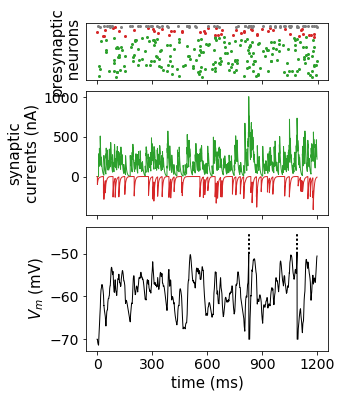

In [5]:
#########################################################
############# Running an example simulation   ###########
## ==> Excitatory cell   ################################
#########################################################

from model import Model;Model2 = Model.copy() # importing default model

# Importing functions for making single cell simulations
from neural_network_dynamics.transfer_functions.single_cell_protocol import run_sim as single_cell_sim
from neural_network_dynamics.transfer_functions.plots import plot_single_cell_sim
Model2['NRN_KEY'] = 'RecExc' # we stimulate the neuron corresponding to the following key
Model2['N_SEED'] = 1 # only one simulation for illustration
# with the afferent populations:
Model2['POP_STIM'] = ['RecExc', 'RecInh', 'AffExc']
# at the presynaptic frequencies:
Model2['RATES'] = {'F_RecExc':1.,'F_AffExc':6., 'F_RecInh':1.}
# Simulation parameters
Model2['dt'], Model2['tstop']= 0.1, 1200
data = single_cell_sim(Model2, with_Vm=1, with_synaptic_currents=True);
plot_single_cell_sim(data, savefig='figures/illustr.png', XTICKS=np.arange(5)*300);

In [7]:
#########################################################
############# Running an example simulation   ###########
## ==> Inhibitory cell (i.e. with disinhibition)   ######
#########################################################

from model import Model;Model2 = Model.copy() # importing default model

# Importing functions for making single cell simulations
from neural_network_dynamics.transfer_functions.single_cell_protocol import run_sim as single_cell_sim
from neural_network_dynamics.transfer_functions.plots import plot_single_cell_sim

Model2['NRN_KEY'] = 'RecInh' # we stimulate the neuron corresponding to the following key
Model2['N_SEED'] = 1 # only one simulation for illustration
# with the afferent populations:
Model2['POP_STIM'] = ['RecExc', 'RecInh', 'AffExc', 'DsInh']
# at the presynaptic frequencies:
Model2['RATES'] = {'F_RecExc':1.,'F_AffExc':6., 'F_RecInh':1., 'F_DsInh':4.}
# Simulation parameters
Model2['dt'], Model2['tstop']= 0.1, 1200
# running simulation
data = single_cell_sim(Model2, with_Vm=1, with_synaptic_currents=True);
# then plot
plot_single_cell_sim(data, savefig='figures/illustr.png', XTICKS=np.arange(5)*300);

[0]


In [8]:
import os
from model import pass_arguments_of_new_model, Model
from neural_network_dynamics.transfer_functions.single_cell_protocol import my_logspace

def build_up_transfer_function_scan(Model, key = 'RecExc', filename='data.npy', N_SEED=2,
                                    Fexc=my_logspace(1e-2, 40, 10),
                                    Finh=my_logspace(1e-2, 40, 10),
                                    Faff=my_logspace(3., 20, 10),
                                    Fdsnh=[],
                                    dt=0.1, tstop=5000):
    tf_file = 'neural_network_dynamics/transfer_functions/single_cell_protocol.py'
    # parameters in model
    Model['dt'], Model['tstop'], Model['N_SEED'] = dt, tstop, N_SEED
    S = 'python '+tf_file+' --TF '+pass_arguments_of_new_model(Model)
    
    S += ' --F_RecExc_array'
    for fe in Fexc: S += ' '+str(fe)
    S += ' --F_RecInh_array'
    for fi in Finh: S += ' '+str(fi)
    S += ' --F_AffExc_array'
    for fa in Faff: S += ' '+str(fa)
    
    if len(Fdsnh)>0:
        S += ' --POP_STIM \'RecExc\' \'RecInh\' \'AffExc\' \'DsInh\' '
        S += ' --F_DsInh_array'
        for fd in Fdsnh: S += ' '+str(fd)
    else:
        S += ' --POP_STIM \'RecExc\' \'RecInh\' \'AffExc\' '
        
    S += ' --NRN_KEY '+key # cell ID
    S += ' --filename '+filename+' \n'
    print('sget',filename)
    return S

data_root = 'sparse_vs_balanced/data/'

S1 = build_up_transfer_function_scan(Model, key = 'RecExc', filename=data_root+'tf_data_exc.npy',
                                     Fexc=my_logspace(1e-2, 30, 30),
                                     Finh=my_logspace(1e-2, 30, 15),
                                     Faff=my_logspace(3., 25, 13),
                                     N_SEED=10, Fdsnh=[], tstop=30000)

S2 = build_up_transfer_function_scan(Model, key = 'RecInh', filename=data_root+'tf_data_inh.npy',
                                     Fexc=my_logspace(1e-2, 30, 30),
                                     Finh=my_logspace(1e-2, 30, 15),
                                     Faff=my_logspace(3., 25, 13),
                                     N_SEED=10, Fdsnh=[], tstop=30000)
# =============================================
# we build up a bash script of those config to be
# run (typically on a server)
# =============================================
bash_file = open('sparse_vs_balanced/bash_scan/tf_scan.sh', 'w')
bash_file.write(S1+S2)
bash_file.close()

sget sparse_vs_balanced/data/tf_data_exc.npy
sget sparse_vs_balanced/data/tf_data_inh.npy


## Transfer function of Excitatory cells

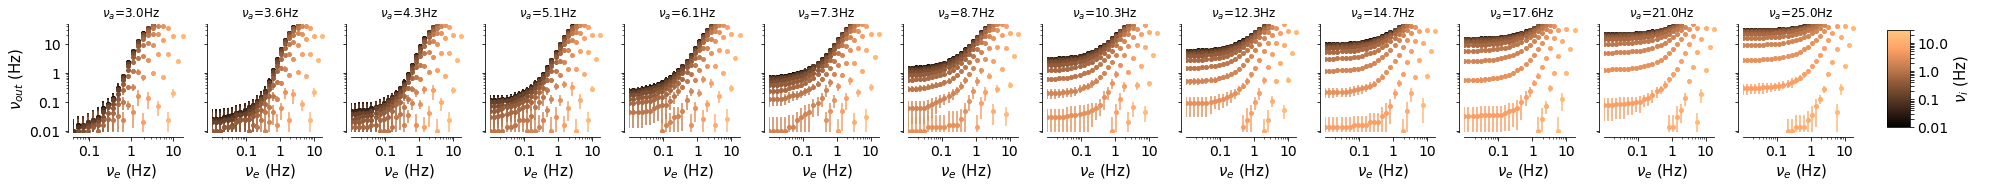

In [9]:
"""
Numerical simulations of single cell dynamics
         varying presynaptic frequencies and measuring output rate
"""
## let's have a look at a subsample of the data
import os
%matplotlib inline
data = np.load('sparse_vs_balanced/data/tf_data_exc.npy').item()
from neural_network_dynamics.theory.tf import make_tf_plot
fig = make_tf_plot(data, ylim=[0.01,50]);
#fig.savefig(desktop+'temp.svg')

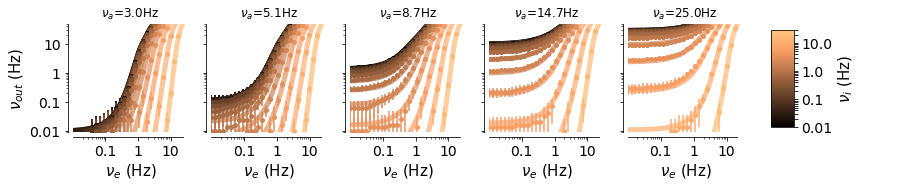

In [11]:
"""
Fitting those data to obtain an analytical function
(see details in the methods)
"""
%matplotlib inline
### loading the output of the numerical simulations (single cell)
data = np.load('sparse_vs_balanced/data/tf_data_exc.npy').item()
### loading the output of the numerical simulations (single cell)
from neural_network_dynamics.theory.fitting_tf import fit_data
data['Model']['COEFFS'] = fit_data(data, order=2)
### Now plotting the ouput of the fit
from neural_network_dynamics.theory.tf import make_tf_plot
fig = make_tf_plot(data, ylim=[0.01,50],
                   col_subsmpl=np.concatenate([np.arange(5)*3]),
                   with_theory=True)
#fig.savefig(desktop+'temp.svg')
# STORING COEFFICIENTS:
np.save('sparse_vs_balanced/data/COEFFS_RecExc.npy', data['Model']['COEFFS'])

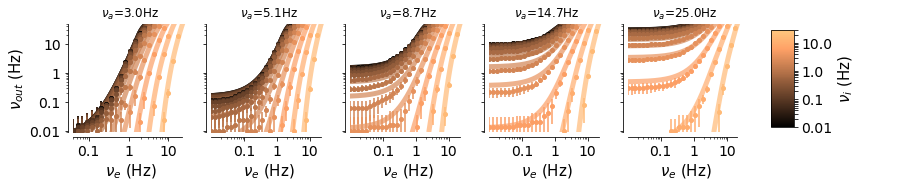

In [14]:
"""
For comparison, keeping only the first order terms in the threshold
(not so much difference, but a bit worse)
"""

### loading the output of the numerical simulations (single cell)
data = np.load('sparse_vs_balanced/data/tf_data_exc.npy').item()
### loading the output of the numerical simulations (single cell)
from neural_network_dynamics.theory.fitting_tf import fit_data
data['Model']['COEFFS'] = fit_data(data, order=1)
### Now plotting the ouput of the fit
from neural_network_dynamics.theory.tf import make_tf_plot
fig = make_tf_plot(data, ylim=[0.01,50],
                   col_subsmpl=np.concatenate([np.arange(5)*3]),
                   with_theory=True)

## Transfer function of inhibitory cells

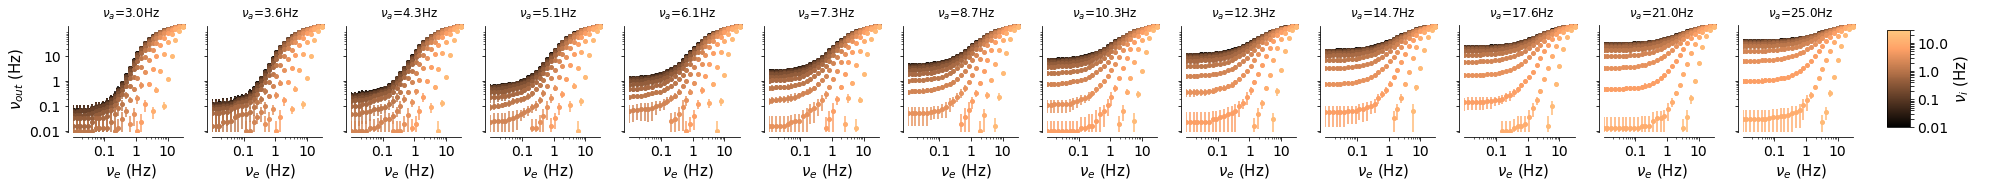

In [15]:
"""
Numerical simulations of single cell dynamics
         varying presynaptic frequencies and measuring output rate
"""
## let's have a look at a subsample of the data
import os
%matplotlib inline
data = np.load('sparse_vs_balanced/data/tf_data_inh.npy').item()
from neural_network_dynamics.theory.tf import make_tf_plot
fig = make_tf_plot(data, ylim=[0.01,200])

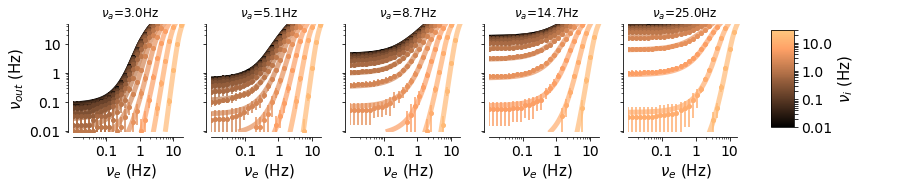

In [17]:
"""
Fitting those data to obtain an analytical function
(see details in the methods)
"""
%matplotlib inline
### loading the output of the numerical simulations (single cell)
data = np.load('sparse_vs_balanced/data/tf_data_inh.npy').item()
### loading the output of the numerical simulations (single cell)
from neural_network_dynamics.theory.fitting_tf import fit_data
data['Model']['COEFFS'] = fit_data(data, order=2)
### Now plotting the ouput of the fit
from neural_network_dynamics.theory.tf import make_tf_plot
fig = make_tf_plot(data, ylim=[0.01,50],
                   col_subsmpl=np.concatenate([np.arange(5)*3]),
                   with_theory=True)
# STORING COEFFICIENTS:
np.save('sparse_vs_balanced/data/COEFFS_RecInh.npy', data['Model']['COEFFS'])
#fig.savefig(desktop+'temp.svg')

## Mean-field analysis of network dynamics

We build up a dynamical system describing population dynamics (based
on the previously determined transfer functions) and we look for the
stationary solution of the dynamical system (i.e. the stable fixed
point of the dynamics).

In [19]:
%matplotlib inline
from model import Model; Model2 = Model.copy()
from neural_network_dynamics.theory.mean_field import find_fp, show_phase_space, get_full_statistical_quantities
Model2['COEFFS_RecExc'] = np.load('sparse_vs_balanced/data/COEFFS_RecExc.npy')
Model2['COEFFS_RecInh'] = np.load('sparse_vs_balanced/data/COEFFS_RecInh.npy')

### Illustrating the procedure on the two specific levels (sparse activity
and balanced activity) picked for illustration

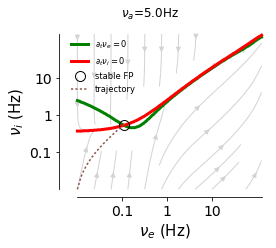

In [21]:
Faff = 5. # level of afferent input (Sparse Activity setting)

fig, SA_output = show_phase_space(Model2,
                                  with_trajectory=[0.01, 0.01], t=np.arange(5000)*1e-4, 
                                  KEY1='RecExc', KEY2='RecInh',
                                  F1 = np.logspace(-2., 2.1, 200),
                                  F2 = np.logspace(-2., 2.2, 500),
                                  KEY_RATES1 = ['AffExc'], VAL_RATES1=[Faff],
                                  KEY_RATES2 = ['AffExc'], VAL_RATES2=[Faff])
fig.suptitle('$\\nu_a$='+str(Faff)+'Hz')
np.savez('sparse_vs_balanced/data/SA_theory.npz', **SA_output)
#fig.savefig(desktop+'temp.svg')

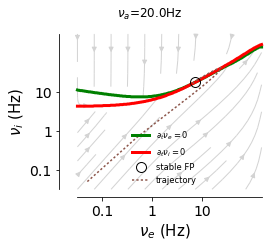

In [22]:
Faff = 20. # level of afferent input

fig, BA_output = show_phase_space(Model2,
                                  with_trajectory=[0.05, 0.05], t=np.arange(5000)*1e-4,
                                  KEY1='RecExc', KEY2='RecInh',
                                  F1 = np.logspace(-1.5, 2.2, 200),
                                  F2 = np.logspace(-1.5, 2.5, 500),
                                  KEY_RATES1 = ['AffExc'], VAL_RATES1=[Faff],
                                  KEY_RATES2 = ['AffExc'], VAL_RATES2=[Faff]);
fig.suptitle('$\\nu_a$='+str(Faff)+'Hz')
np.savez('sparse_vs_balanced/data/BA_theory.npz', **BA_output)
#fig.savefig(desktop+'temp.svg')

In [23]:
print('In absence of conductance-based interactions, the BA variance would be:')
print(round(1e3*BA_output['Isyn_RecExc']['sV0'], 1), 'mV')

In absence of conductance-based interactions, the BA variance would be:
19.0 mV


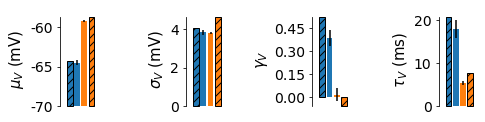

In [25]:
%matplotlib inline
from data_analysis.IO.hdf5 import load_dict_from_hdf5
sas_data = load_dict_from_hdf5('sparse_vs_balanced/data/sas.h5')
bs_data = load_dict_from_hdf5('sparse_vs_balanced/data/bs.h5')
BA_theory = dict(np.load('sparse_vs_balanced/data/BA_theory.npz').items())
SA_theory = dict(np.load('sparse_vs_balanced/data/SA_theory.npz').items())

from sparse_vs_balanced.plot_state_signature import Vm_signature
fig = Vm_signature([sas_data, bs_data], TH_DATA = [SA_theory, BA_theory])

### Running this theoretical analysis for all levels of afferent input

In [11]:
# importing the levels of the numerical simulations
from sparse_vs_balanced.varying_AffExc import get_scan
# _, FAFF, _, _ = get_scan({},
#                             filename='sparse_vs_balanced/data/varying_AffExc.zip')

FAFF2 = np.logspace(np.log(FAFF[0])/np.log(10), np.log(FAFF[-1])/np.log(10), 100)
FE, FI, IRATIO = [], [], []
for faff in FAFF2:
    fe_fp, fi_fp = find_fp(Model2,
                           t = np.arange(5000)*1e-4, X0=[0.1, 0.1],
                           KEY1='RecExc', KEY2='RecInh',
                           KEY_RATES1 = ['AffExc'], VAL_RATES1=[faff],
                           KEY_RATES2 = ['AffExc'], VAL_RATES2=[faff])
    output = get_full_statistical_quantities(Model2, [fe_fp, fi_fp],
                           KEY1='RecExc', KEY2='RecInh',
                           KEY_RATES1 = ['AffExc'], VAL_RATES1=[faff],
                           KEY_RATES2 = ['AffExc'], VAL_RATES2=[faff])
    FE.append(output['F_RecExc'])
    FI.append(output['F_RecInh'])
    # on excitatory currents
    Isyn = output['Isyn_RecExc']
    IRATIO.append(np.abs(Isyn['RecInh']/(Isyn['RecExc']+Isyn['AffExc'])))
np.save('sparse_vs_balanced/data/varying_AffExc_theory.npy', [FAFF2, FE, FI, IRATIO])    

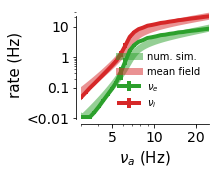

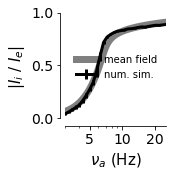

In [28]:
%matplotlib inline
FAFF2, FE, FI, Iratio = np.load('sparse_vs_balanced/data/varying_AffExc_theory.npy')
FE[FE<0.01], FI[FI<0.01] = 0.011, 0.011 # same thing than for numerical sim. limiting the range of data vis.

from sparse_vs_balanced.plot_state_signature import plot_act_vs_aff_level
fig1, fig2 = plot_act_vs_aff_level('sparse_vs_balanced/data/varying_AffExc_analyzed.npy',
                                      Iratio_th=Iratio, Fe_th=FE, Fi_th=FI, Fa_th=FAFF2)